# M1グランプリを主成分分析

## import

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sns.set(style="ticks")

In [3]:
# matplotlibで日本語を表示するための設定です．
from matplotlib.font_manager import FontProperties
font_path = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

In [4]:
# 主成分分析（PCA）用のモジュールです．
from sklearn.decomposition import PCA

# 前処理用のモジュールです．
from sklearn import preprocessing

In [5]:
# 実効的に無視して問題ないwarningを非表示にします．
# いつか対応します…．
import warnings
warnings.filterwarnings("ignore")

## Data

In [6]:
df = pd.read_csv("data/2017.csv")
df

,グループ名,上沼,松本,大吉,小朝,礼二,渡辺,巨人,結果
0,とろサーモン,93,92,93,93,93,93,88,通過
1,和牛,95,93,94,94,93,92,92,通過
2,ミキ,95,94,91,92,91,94,93,通過
3,かまいたち,89,91,92,90,94,89,95,敗退
4,スーパーマラドーナ,89,90,93,91,92,91,94,敗退
5,ジャルジャル,90,95,91,90,89,88,93,敗退
6,さや香,90,90,90,90,90,91,87,敗退
7,ゆにばーす,90,87,92,91,90,87,89,敗退
8,カミナリ,90,85,91,90,89,86,87,敗退
9,マヂカルラブリー,83,84,88,89,88,89,86,敗退


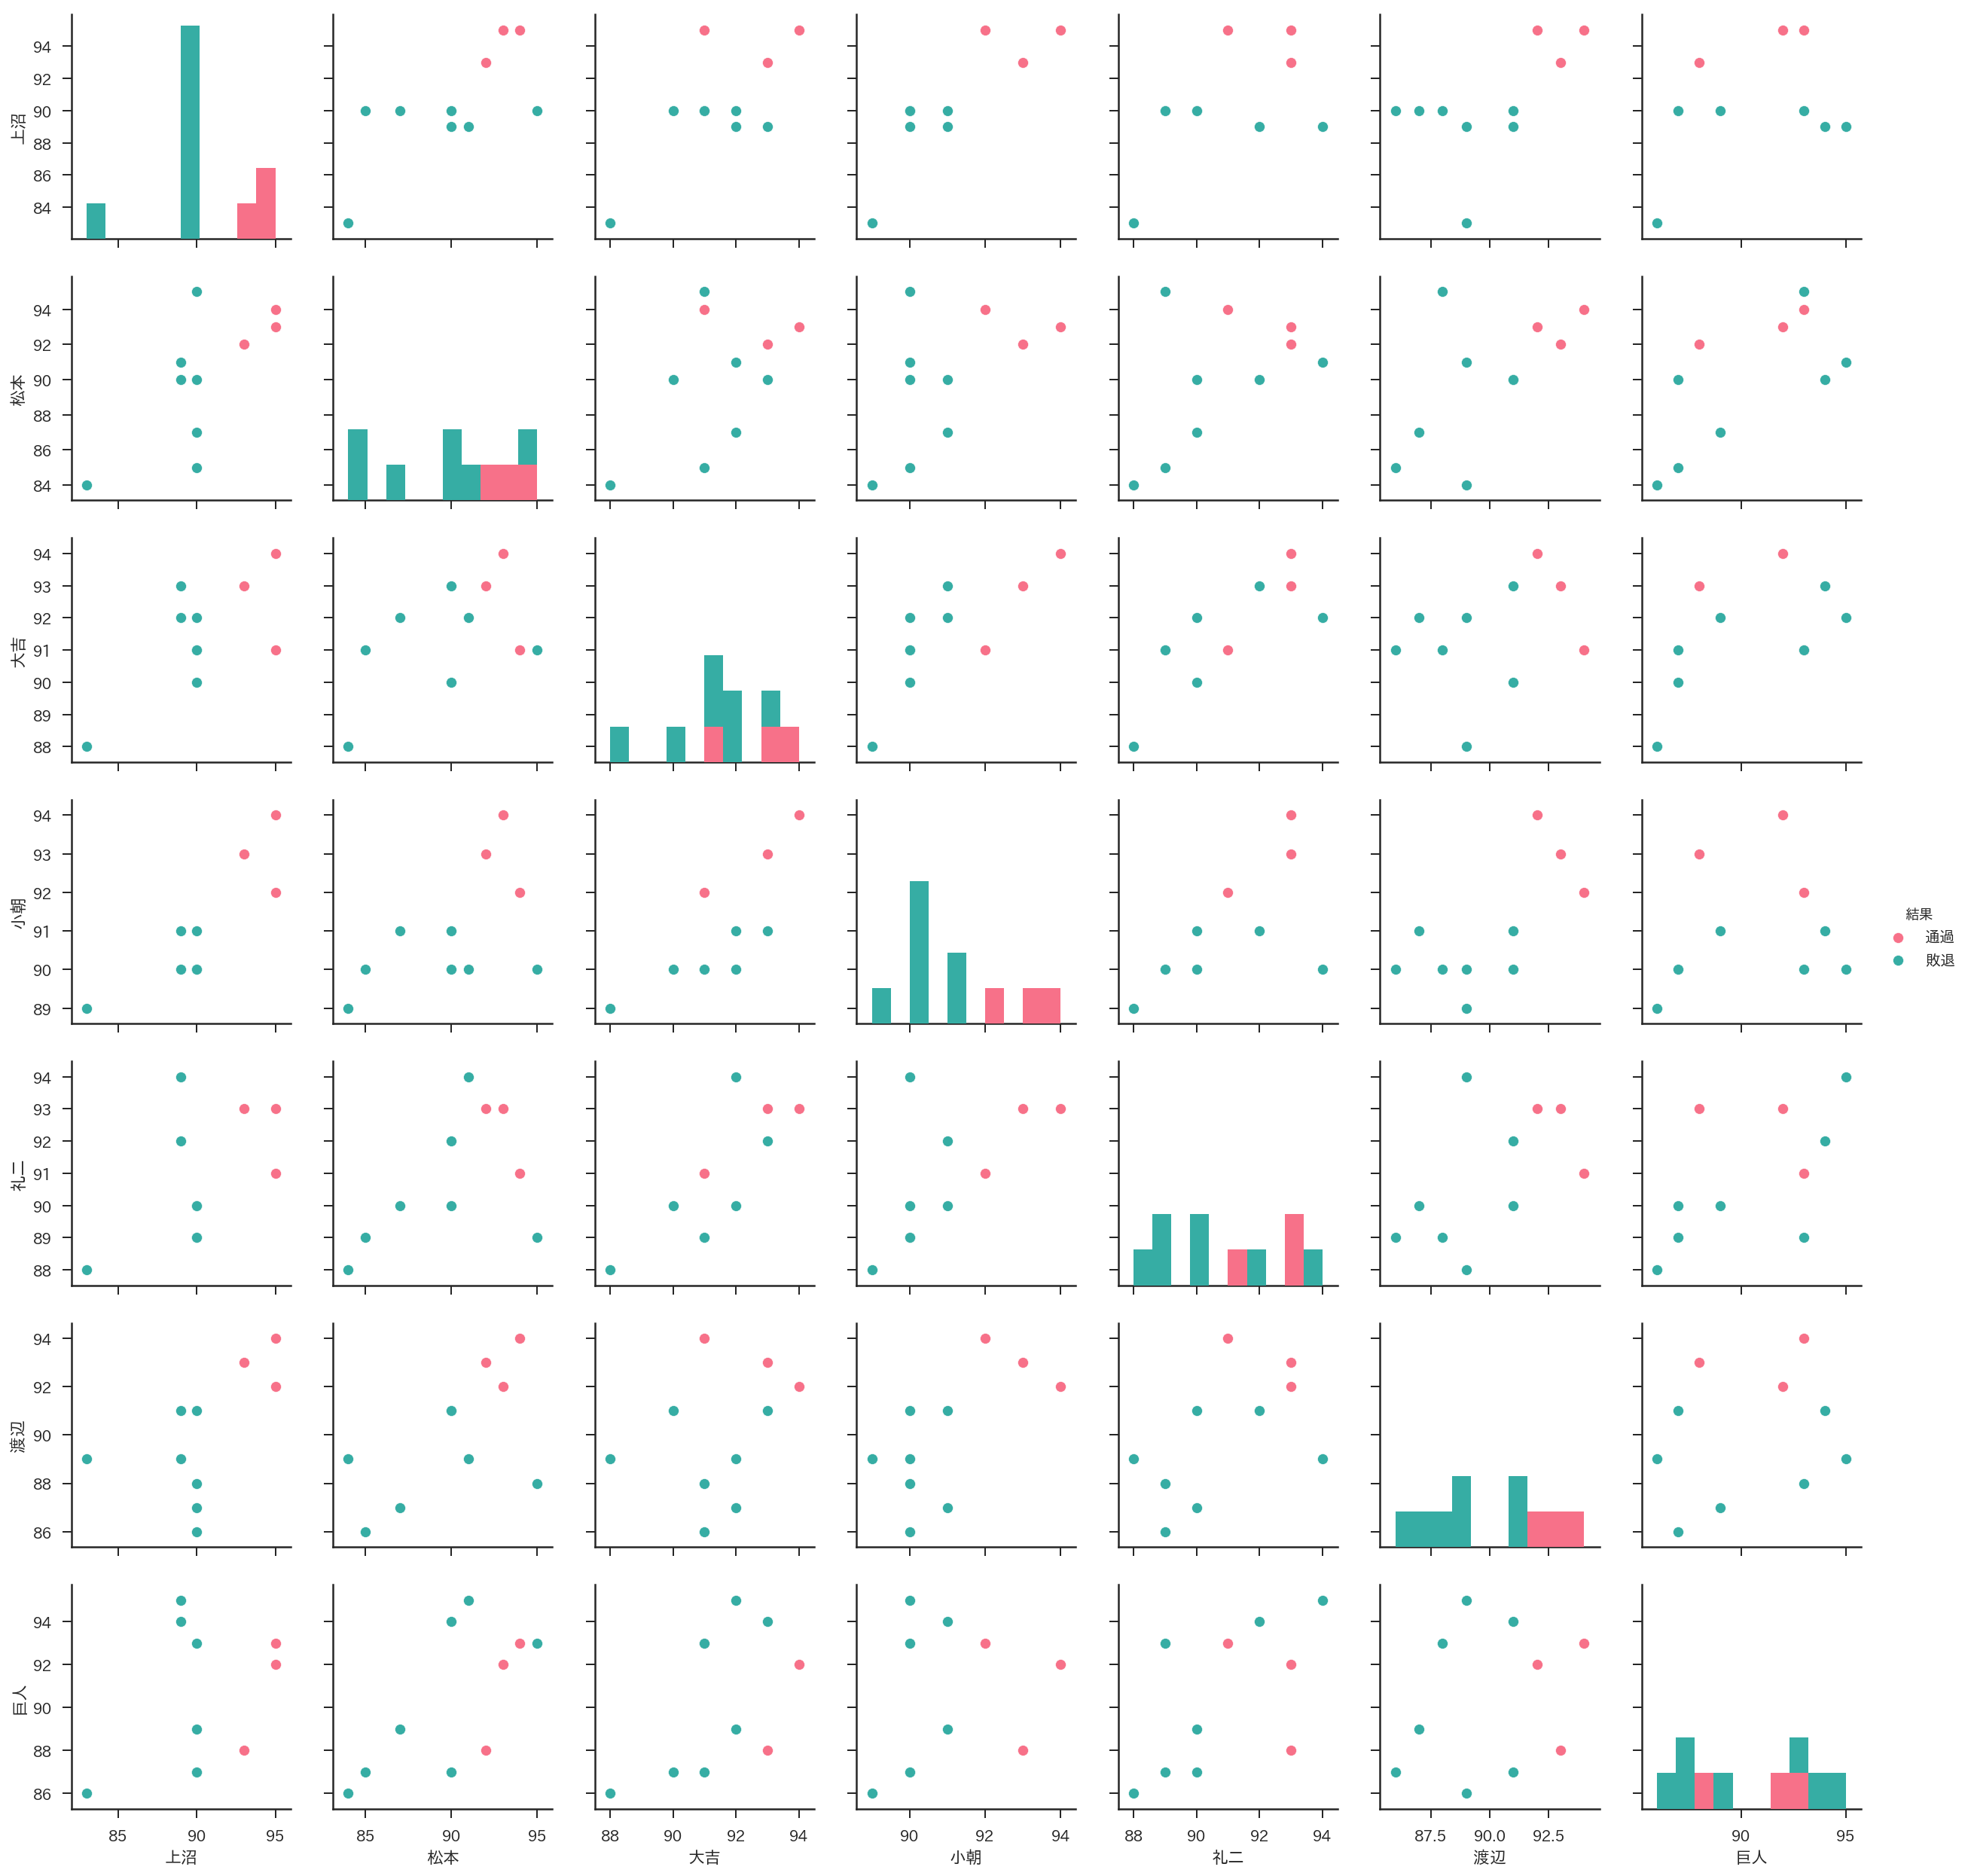

In [7]:
sns.pairplot(df, hue="結果", palette="husl")

何となく，上沼さん，小朝さん，渡辺さんの評点が実際の順位と相関が強いように見えます．
しかしこのままでは，参加者同士にどのような相関関係があるのか，ひと目ではわかりにくいです．
そこで，**主成分分析**を使い，審査結果を二次元空間に圧縮してみます．

## Principle component analysis

In [8]:
x = np.array(df.values)[:,1:-1]
x_scaled = preprocessing.scale(x)
t = np.array([1 if i=="通過" else 0 for i in df["結果"].values])

In [9]:
x_pca = PCA(n_components=2).fit_transform(x_scaled)

まず，主因子空間に各参加者をプロットします．

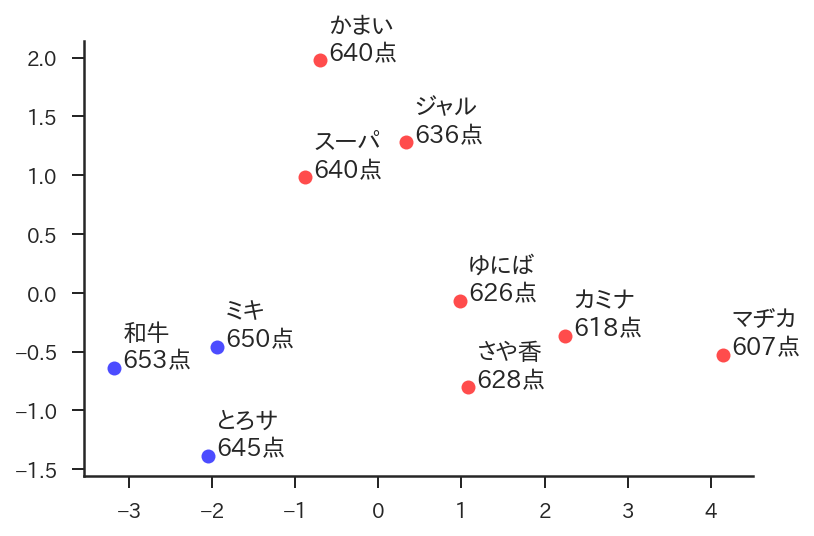

In [10]:
for ii in range(len(t)):
    plt.plot(x_pca[ii, 0], x_pca[ii, 1], c= 'b' if t[ii] else 'r', marker='o',
             alpha=0.7)
    plt.annotate("{}\n{}点".format(df.iloc[ii, 0][:3], sum(df.iloc[ii, 1:-1])),
                 x_pca[ii]+[.1, 0], )
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

横軸は総合点に対応しそうですが，縦軸は謎です．そこで，主成分空間に各審査員をプロットしてみます．

((-1, 1), (-1, 1))

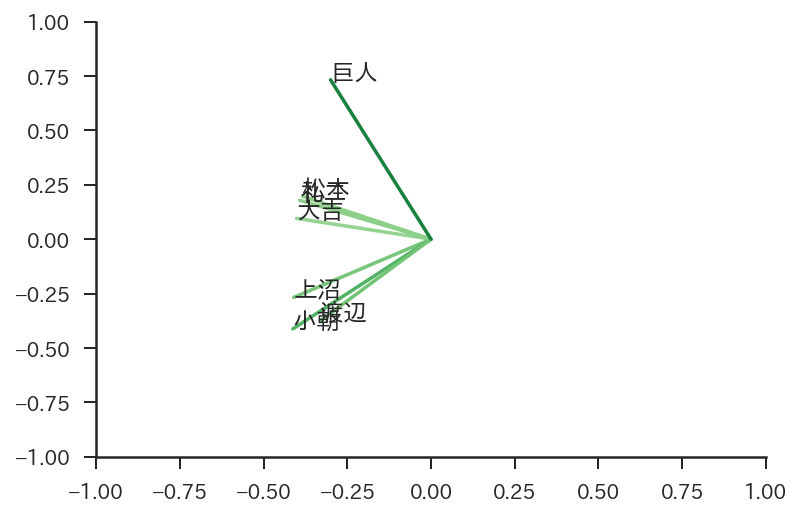

In [17]:
judge = df.columns[1:-1]
comps = PCA(n_components=2).fit(x_scaled).components_
for ii in range(len(judge)):
    plt.plot([0, comps[0, ii]], [0, comps[1, ii]], 
              c=cm.Greens(np.linalg.norm(comps[:, ii])))
    plt.annotate(judge[ii], comps[:, ii])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([-1, 1]), plt.ylim([-1, 1])

主成分は三つのグループで構成されることがわかります．ひとつ目は，吉本出身以外の審査員（上沼さん，渡辺さん，小朝さん）のグループ，ふたつ目は，吉本出身のプレーヤー層（松本さん，礼二さん，大吉さん），そして三つ目は，巨人さんです．
つまり縦軸は，吉本出身の審査員に好かれやすいか，それ以外の審査員に好かれやすいかを示してる可能性があります．非常に面白いですね．

## 振り返ってみる

せっかくなので，過去のM1の結果も分析してみます．上記の処理を一括して行う関数`plot_m1()`を定義します．

In [18]:
def plot_m1(year=2017):
    df = pd.read_csv("data/{}.csv".format(year))
    x = np.array(df.values)[:, 1:-1]
    t = np.array([1 if i=="通過" else 0 for i in df["結果"].values])
    x_scaled = preprocessing.scale(x)
    x_pca = PCA(n_components=2).fit_transform(x_scaled)
    
    plt.figure(figsize=[10, 4])
    
    plt.subplot(1, 2, 1) # 主成分空間で参加者をプロットします．
    for ii in range(len(t)):
        plt.plot(x_pca[ii, 0], x_pca[ii, 1], 
                 c= 'b' if t[ii] else 'r', marker='o', alpha=0.7)
        plt.annotate(
            "{}\n{}点".format(df.iloc[ii, 0][:3], sum(df.iloc[ii, 1:-1])),
            x_pca[ii]+[.1, 0])
    plt.xlim([min(x_pca[:, 0])-.5, max(x_pca[:, 0])+.8])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    plt.subplot(1, 2, 2) # 主成分空間で審査員をプロットします．
    judge = df.columns[1:-1]
    comps = PCA(n_components=2).fit(x_scaled).components_
    for ii in range(len(judge)):
        plt.plot([0, comps[0, ii]], [0, comps[1, ii]], 
                  c=cm.Greens(np.linalg.norm(comps[:, ii])))
        plt.annotate(judge[ii], comps[:, ii])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlim([-1, 1]), plt.ylim([-1, 1])
    
    return df

,得点詳細 グループ名,紳助,松本,鴻上,石井,小朝,青島,きよし,札幌,大阪,福岡,結果
0,中川家,80,70,85,90,90,90,91,65,89,79,通過
1,ハリガネロック,75,60,85,92,70,90,95,85,85,72,通過
2,アメリカザリガニ,74,65,84,92,80,85,88,84,57,87,敗退
3,ますだおかだ,78,70,84,88,80,80,95,75,52,68,敗退
4,麒麟,75,75,83,90,65,75,79,54,82,63,敗退
5,フットボールアワー,66,55,82,82,80,80,90,62,83,46,敗退
6,キングコング,74,55,83,76,70,75,95,64,55,60,敗退
7,チュートリアル,60,50,75,68,75,75,80,38,67,49,敗退
8,DonDokoDon,64,65,84,82,65,85,75,47,18,29,敗退
9,おぎやはぎ,50,60,73,82,75,80,77,22,9,12,敗退


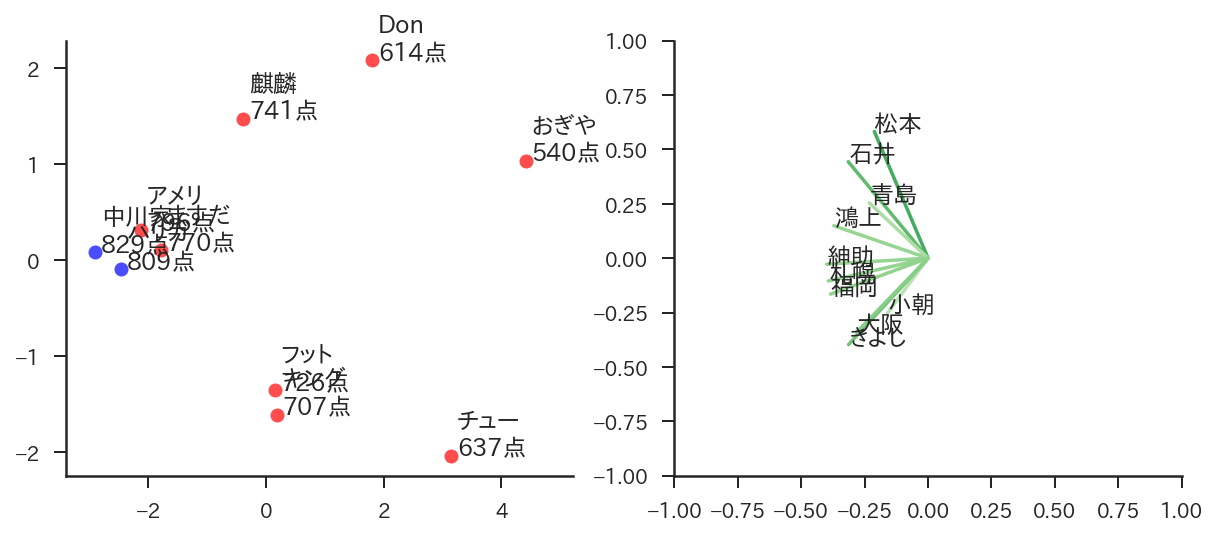

In [19]:
plot_m1(2001)

,得点詳細 グループ名,紳助,松本,大竹,石井,洋七,カウス,談志,結果
0,ますだおかだ,89,70,92,90,96,95,80,通過
1,フットボールアワー,89,85,91,95,94,97,70,通過
2,笑い飯,86,80,80,84,84,83,70,通過
3,おぎやはぎ,76,80,79,79,85,82,80,敗退
4,ハリガネロック,75,65,83,81,86,85,70,敗退
5,テツandトモ,76,65,77,82,79,90,70,敗退
6,スピードワゴン,73,75,80,86,86,85,50,敗退
7,ダイノジ,83,60,78,78,81,84,70,敗退
8,アメリカザリガニ,73,60,78,78,83,83,70,敗退


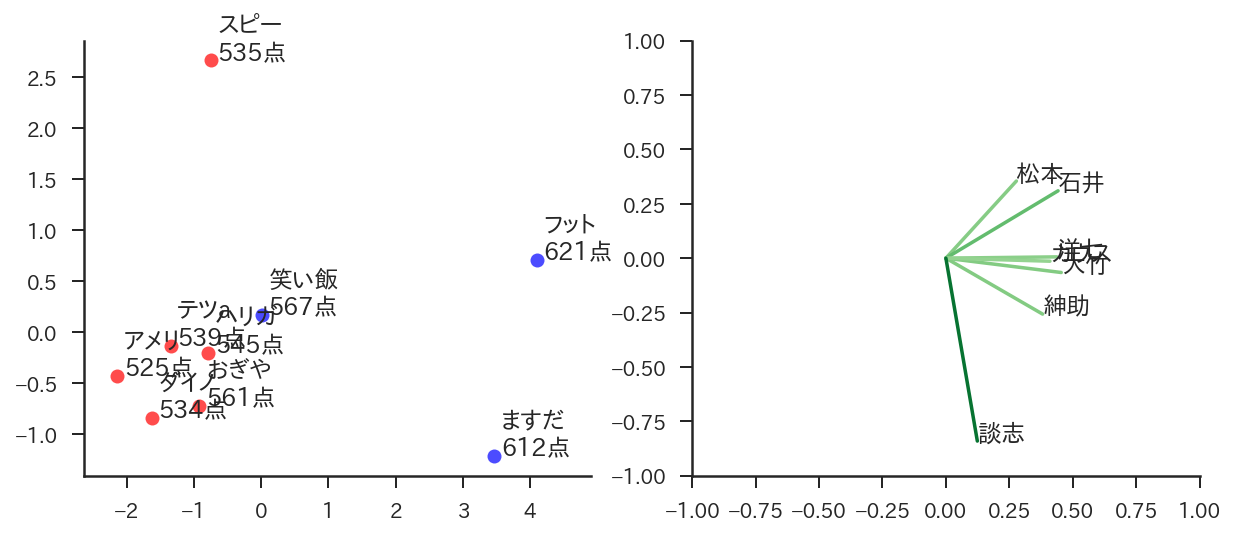

In [20]:
plot_m1(2002)

,グループ名,紳助,松本,南原,洋七,石井,大竹,カウス,結果
0,フットボールアワー,98,97,89,97,95,89,98,通過
1,笑い飯,99,95,90,95,92,90,95,通過
2,アンタッチャブル,92,84,85,90,92,87,86,通過
3,2丁拳銃,91,80,87,95,86,83,86,敗退
4,りあるキッズ,90,85,81,93,85,83,84,敗退
5,スピードワゴン,85,74,81,85,86,82,79,敗退
6,アメリカザリガニ,80,70,84,90,83,76,81,敗退
7,麒麟,84,75,76,84,78,75,82,敗退
8,千鳥,82,70,82,75,84,79,80,敗退


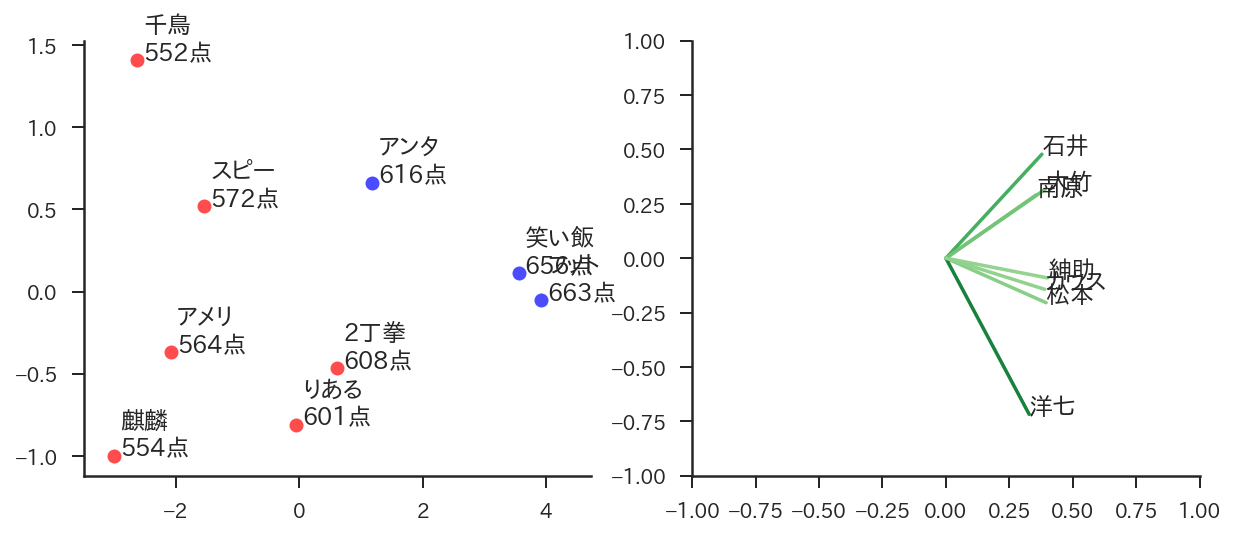

In [21]:
plot_m1(2003)

,グループ名,きよし,南原,大竹,洋七,小朝,石井,カウス,結果
0,アンタッチャブル,97,96,95,97,95,96,97,通過
1,南海キャンディーズ,90,92,86,92,90,95,94,通過
2,麒麟,89,88,89,92,88,92,96,通過
3,タカアンドトシ,86,86,82,91,85,90,95,敗退
4,笑い飯,84,89,82,91,85,89,95,敗退
5,POISON GIRL BAND,87,85,83,81,88,89,90,敗退
6,トータルテンボス,80,84,79,84,84,88,88,敗退
7,東京ダイナマイト,82,80,76,83,87,86,89,敗退
8,千鳥,83,83,81,78,82,82,93,敗退


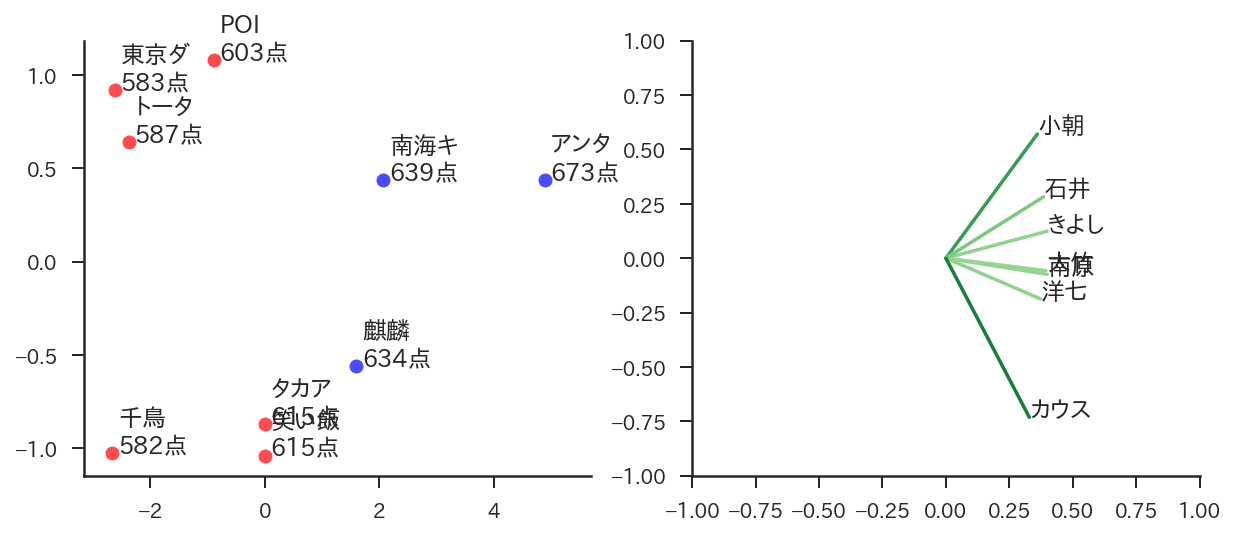

In [22]:
plot_m1(2004)

,グループ名,紳助,松本,渡辺,大竹,洋七,石井,カウス,結果
0,ブラックマヨネーズ,95,95,93,90,96,94,96,通過
1,笑い飯,85,95,90,85,91,92,95,通過
2,麒麟,88,90,91,90,95,95,97,通過
3,品川庄司,85,90,87,89,95,91,89,敗退
4,チュートリアル,85,95,86,84,86,95,91,敗退
5,千鳥,82,80,89,88,86,89,93,敗退
6,タイムマシーン3号,76,75,83,82,82,85,88,敗退
7,アジアン,75,70,80,82,81,86,90,敗退
8,南海キャンディーズ,72,75,79,79,79,80,88,敗退


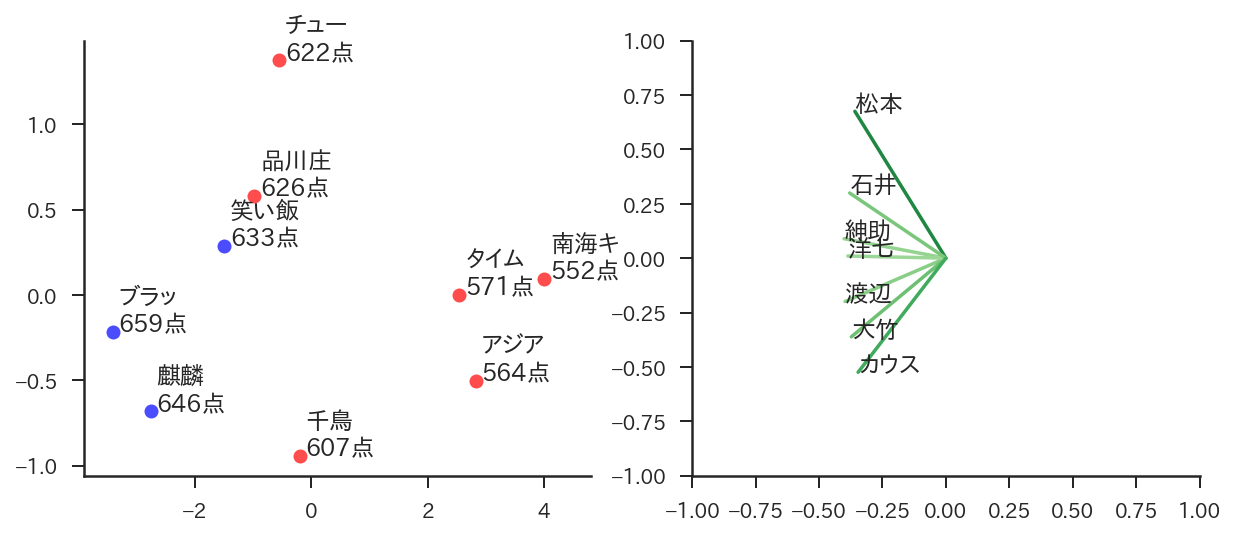

In [23]:
plot_m1(2005)

,グループ名,紳助,松本,南原,渡辺,洋七,大竹,カウス,結果
0,チュートリアル,97,95,95,90,98,92,97,通過
1,フットボールアワー,90,90,94,90,91,89,96,通過
2,麒麟,88,87,91,89,92,86,94,通過
3,笑い飯,89,89,92,85,90,89,92,敗退
4,トータルテンボス,87,90,88,85,90,83,90,敗退
5,ライセンス,85,85,90,88,89,83,89,敗退
6,ザ・プラン9,83,80,89,80,90,82,93,敗退
7,変ホ長調,82,75,84,79,85,83,88,敗退
8,POISON GIRL BAND,76,85,85,75,81,83,85,敗退


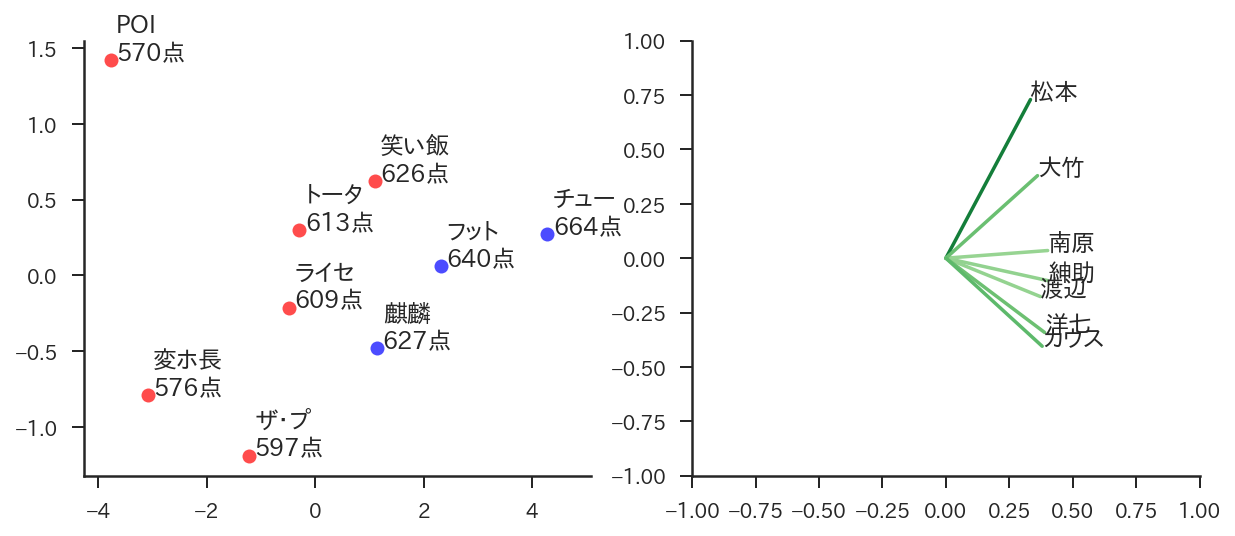

In [24]:
plot_m1(2006)

,グループ名,紳助,松本,上沼,石井,巨人,大竹,カウス,結果
0,サンドウィッチマン,98,95,95,95,92,84,92,通過
1,トータルテンボス,96,93,95,95,90,84,93,通過
2,キングコング,96,93,97,95,88,90,91,通過
3,ハリセンボン,86,88,93,84,86,85,86,敗退
4,笑い飯,85,85,89,85,83,85,92,敗退
5,ザブングル,86,90,92,84,79,84,82,敗退
6,ダイアン,86,85,89,86,81,82,84,敗退
7,千鳥,86,80,85,80,87,81,81,敗退
8,POISON GIRL BAND,75,90,81,82,84,80,85,敗退


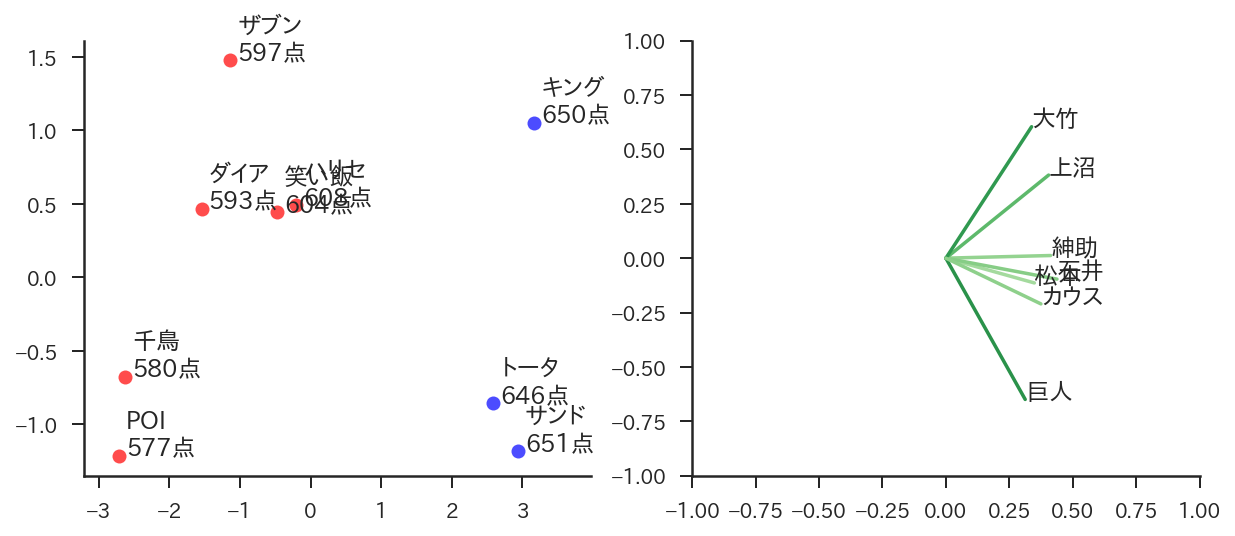

In [25]:
plot_m1(2007)

,グループ名,紳助,松本,上沼,渡辺,巨人,大竹,カウス,結果
0,NON STYLE,94,93,95,90,91,90,91,通過
1,オードリー,89,95,92,92,91,92,98,通過
2,ナイツ,89,93,95,91,89,89,94,通過
3,笑い飯,95,89,95,91,91,88,88,敗退
4,U字工事,91,85,93,90,84,88,92,敗退
5,ダイアン,89,85,90,90,86,86,93,敗退
6,モンスターエンジン,91,83,85,88,89,88,90,敗退
7,キングコング,88,86,90,89,86,87,86,敗退
8,ザ・パンチ,87,80,88,85,83,83,85,敗退


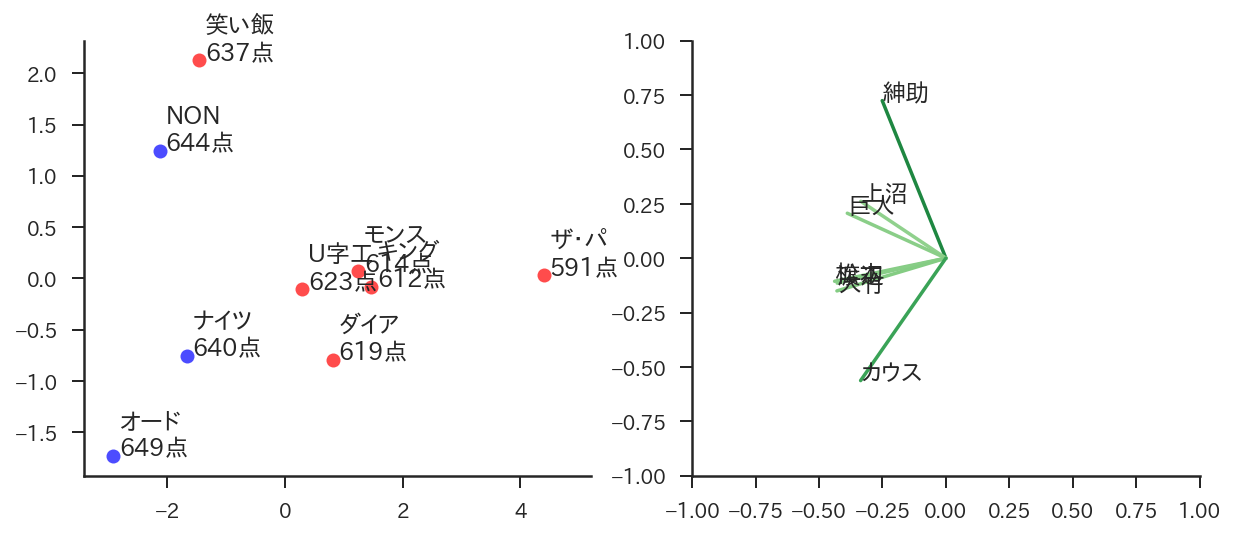

In [26]:
plot_m1(2008)

,グループ名,紳助,松本,上沼,東国原,巨人,渡辺,カウス,結果
0,パンクブーブー,94,93,98,88,90,91,97,通過
1,笑い飯,100,95,98,92,93,92,98,通過
2,NON STYLE,90,92,98,89,87,90,95,通過
3,ナイツ,91,85,93,88,90,91,96,敗退
4,ハライチ,90,88,91,86,89,89,95,敗退
5,東京ダイナマイト,85,88,90,85,86,90,90,敗退
6,モンスターエンジン,89,83,90,85,87,89,87,敗退
7,南海キャンディーズ,85,83,90,89,84,88,88,敗退
8,ハリセンボン,82,80,87,87,85,85,89,敗退


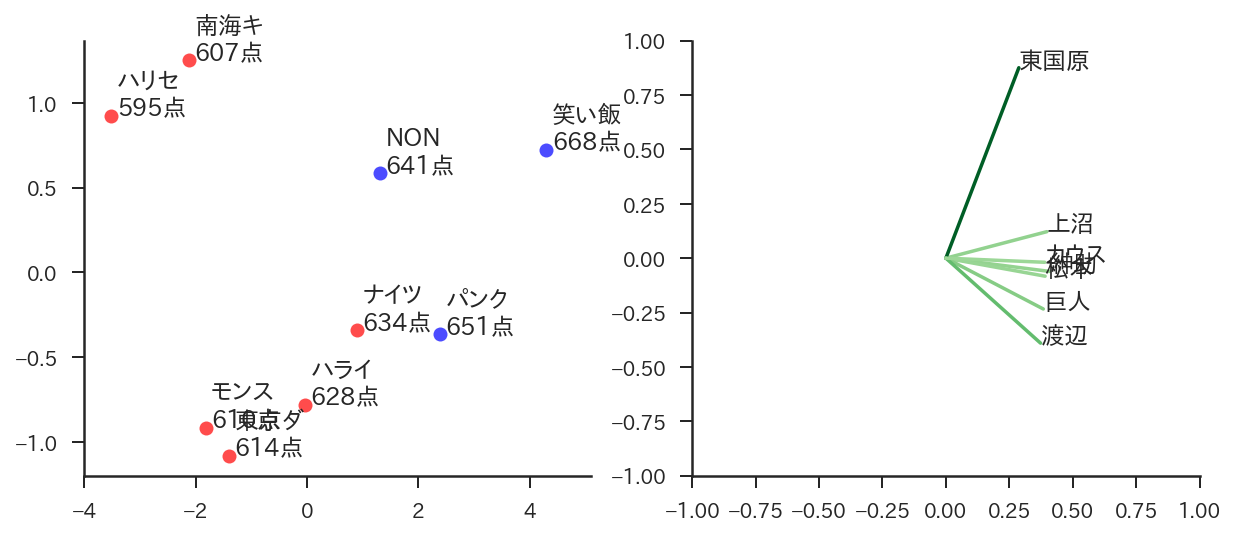

In [27]:
plot_m1(2009)

,グループ名,紳助,松本,南原,大竹,渡辺,宮迫,カウス,結果
0,笑い飯,96,96,98,97,90,95,96,通過
1,スリムクラブ,91,96,93,91,88,91,94,通過
2,パンクブーブー,97,97,94,91,95,98,96,通過
3,ピース,88,89,87,89,89,92,95,敗退
4,銀シャリ,87,90,89,89,87,93,92,敗退
5,ナイツ,92,88,90,90,88,91,87,敗退
6,ハライチ,87,86,89,90,90,90,88,敗退
7,ジャルジャル,86,87,88,89,87,90,79,敗退
8,カナリア,81,85,86,87,85,88,80,敗退


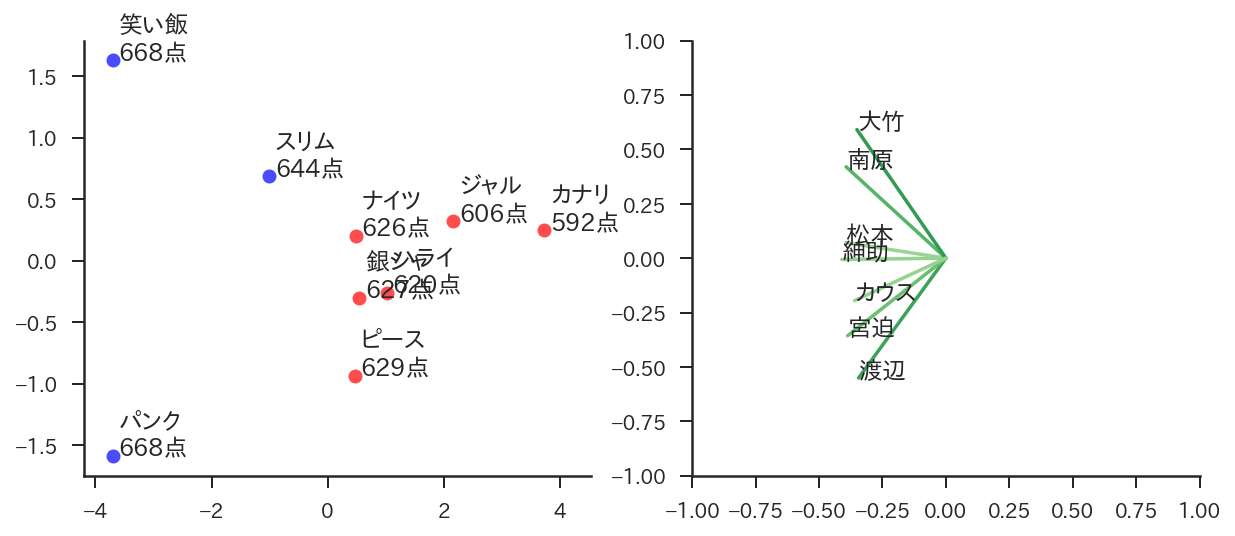

In [28]:
plot_m1(2010)

,グループ名,礼二,増田,岩尾,吉田,徳井,富澤,石田,佐藤,哲夫,結果
0,トレンディエンジェル,94,93,89,93,88,93,92,92,91,通過
1,銀シャリ,91,91,92,89,95,92,87,89,92,通過
2,ジャルジャル,89,89,96,90,96,94,94,93,93,通過
3,タイムマシーン3号,93,90,90,89,88,93,94,91,88,敗退
4,スーパーマラドーナ,92,87,93,90,89,91,88,93,90,敗退
5,和牛,90,92,92,86,90,90,88,90,88,敗退
6,メイプル超合金,87,85,89,85,91,92,89,89,89,敗退
7,馬鹿よ貴方は,88,85,90,83,89,93,83,90,90,敗退
8,ハライチ,92,89,85,83,89,89,86,88,87,敗退


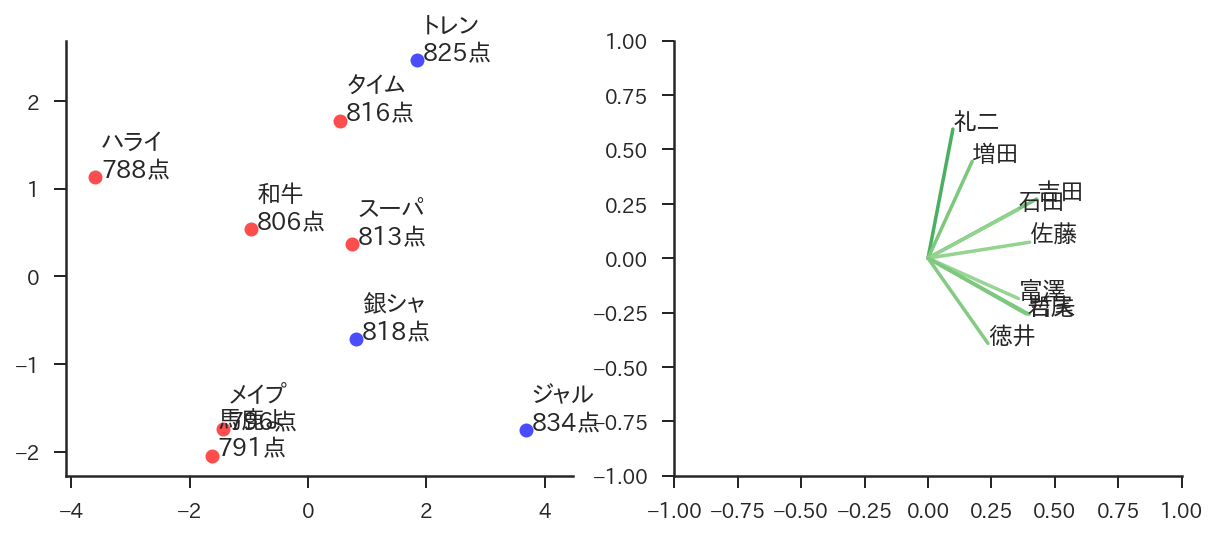

In [29]:
plot_m1(2015)

,グループ名,上沼,松本,大吉,礼二,巨人,結果
0,銀シャリ,95,95,93,91,96,通過
1,和牛,95,93,91,95,95,通過
2,スーパーマラドーナ,93,89,92,95,90,通過
3,さらば青春の光,91,90,90,90,87,敗退
4,アキナ,89,87,89,89,92,敗退
5,ハライチ,93,85,89,88,91,敗退
6,カミナリ,81,89,90,90,91,敗退
7,スリムクラブ,89,90,88,89,85,敗退
8,相席スタート,90,84,87,88,87,敗退


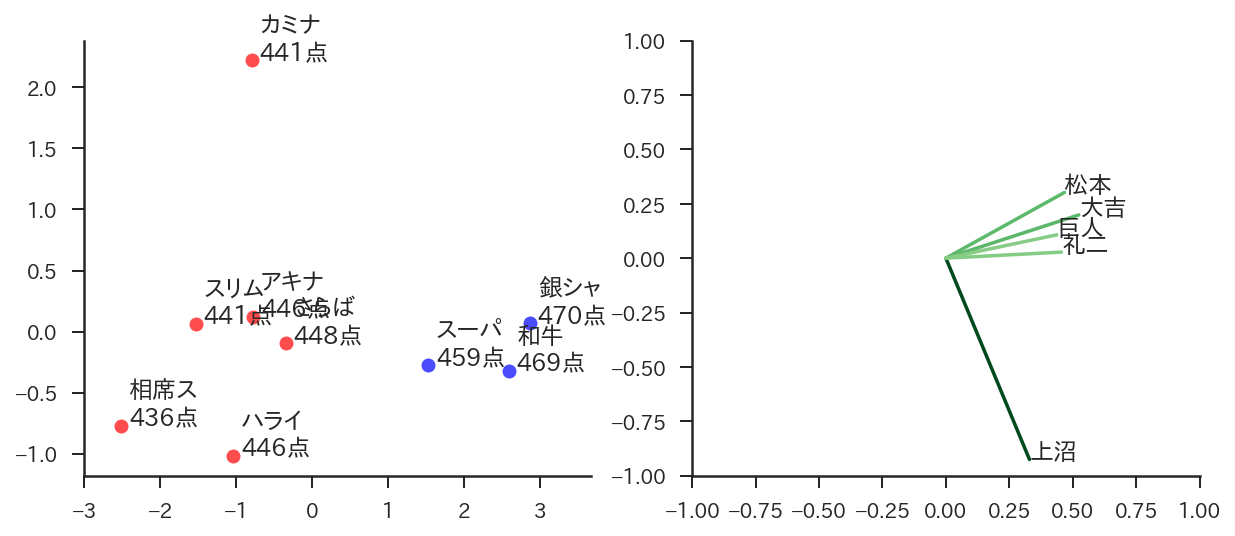

In [30]:
plot_m1(2016)

,グループ名,上沼,松本,大吉,小朝,礼二,渡辺,巨人,結果
0,とろサーモン,93,92,93,93,93,93,88,通過
1,和牛,95,93,94,94,93,92,92,通過
2,ミキ,95,94,91,92,91,94,93,通過
3,かまいたち,89,91,92,90,94,89,95,敗退
4,スーパーマラドーナ,89,90,93,91,92,91,94,敗退
5,ジャルジャル,90,95,91,90,89,88,93,敗退
6,さや香,90,90,90,90,90,91,87,敗退
7,ゆにばーす,90,87,92,91,90,87,89,敗退
8,カミナリ,90,85,91,90,89,86,87,敗退
9,マヂカルラブリー,83,84,88,89,88,89,86,敗退


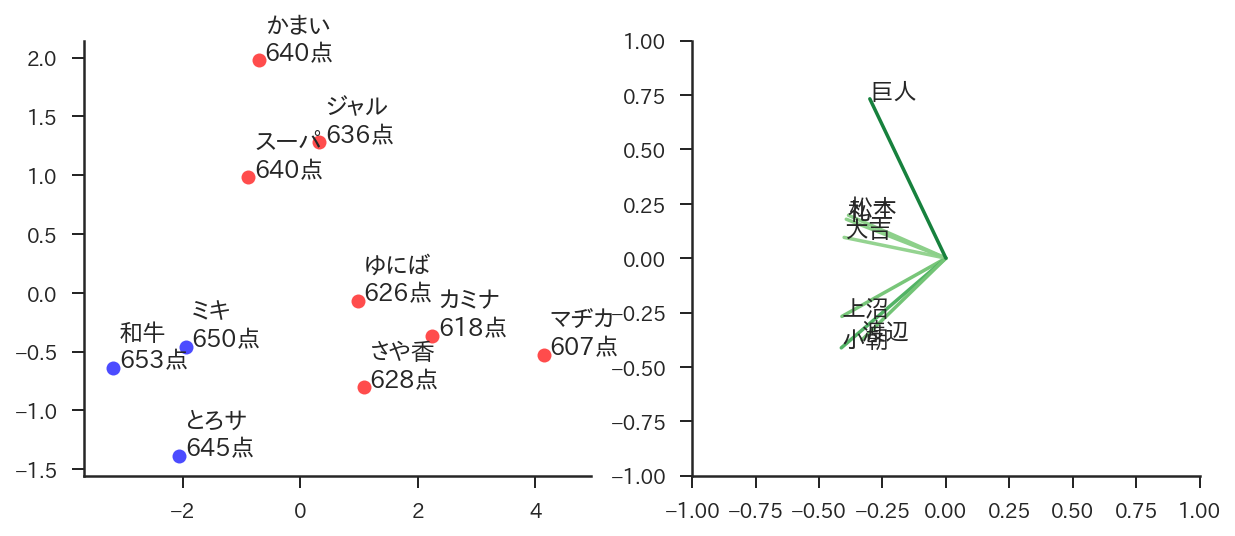

In [31]:
plot_m1(2017)